In [2]:
import collections
import json
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from pymongo import MongoClient
import seaborn as sns


import sys
sys.path.append("../")
import tensorIO
import extractResults

# CMS tensor Description

In [3]:
X, ad, cd = tensorIO.load_tensor('../../cms/data/processed/cms-subsamp1-inout-{0}.dat')
ra = extractResults.reverseAxis(ad)
print X.shape

(4954, 242, 210)


### Get the histogram of the count values

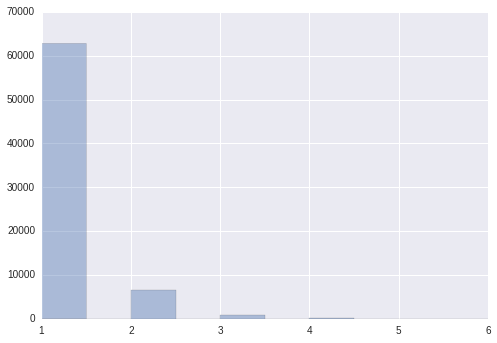

In [4]:
_ = sns.distplot(X.vals.flatten(), bins=10, kde=False)

In [ ]:
# load the dictionary for ccs
ccsDx = json.load(open("/home/joyce/git/data-preprocess/data/single_ccs_dx_labels.json", "r"))
ccsPr = json.load(open("/home/joyce/git/data-preprocess/data/single_ccs_pr_labels.json", "r"))

### Get the top 10 components for diagnosis and procedures

In [ ]:
# get the collection of values
diagMode = collections.Counter(X.subs[:, 1])
topK = diagMode.most_common(10)
print map(lambda (k,v): (ccsDx[ra[1][k]], v), topK)

In [ ]:
# get the collection of values
procMode = collections.Counter(X.subs[:, 2])
topK = procMode.most_common(10)
print map(lambda (k,v): (ccsPr[ra[2][k]], v), topK)

## Explore the effect of the various Granite Parameters on Uniqueness

### Import the needed components and make the connection to the mongo database

In [1]:
mongoC = MongoClient()
db = mongoC.granite
mongoDB = db["granite"] 

### Function to convert the uniqueness data result into list of tuples for specific score type

In [3]:
def get_uniq_score(result, score="fms"):
    vals = []
    exptID = result['id']
    sample1 = result['sample'][0]
    sample2 = result['sample'][1]
    scoreRes = result[score]
    sparsity = result['s']
    theta = result['theta']
    scoreTypes = ["0", "1", "2"]
    for k in scoreTypes:
        v = scoreRes[k]
        n = len(v)
        vals.extend(zip(np.repeat(exptID, n),
                        np.repeat(sample1, n),
                        np.repeat(sample2, n),
                        np.repeat(sparsity[int(k)], n),
                        np.repeat(theta[int(k)], n),
                        np.repeat(score, n),
                        np.repeat(k, n),
                        v))
    return vals

### Function to convert the factor data result into list of tuples

In [4]:
def get_factor_sparsity(result, nnzType="colNNZ"):
    vals = []
    exptID = result['id']
    sample = result['sample']
    runArr = result[nnzType]
    param = [result['s'],
             np.repeat(result['cosReg'], len(result['s'])),
             result['theta']]
    N = len(runArr)
    R = len(runArr[0])
    for n in range(N):
        vals.extend(zip(np.repeat(exptID, R),
                        np.repeat(sample, R),
                        np.repeat(nnzType, R),
                        np.repeat(n, R),
                        runArr[n],
                        np.repeat(param[0][n], R),
                        np.repeat(param[1][n], R),
                        np.repeat(param[2][n], R)))
    return vals

In [5]:
def get_factor_weights(result):
    vals = []
    exptID = result['id']
    sample = result['sample']
    runArr = result['weight']
    R = len(runArr)
    vals.extend(zip(np.repeat(exptID, R),
                    np.repeat(sample, R),
                    runArr))
    return vals

### Function to get the results for a specific experiment ID

In [19]:
def get_expt(mongoDB, expt):
    simScores = []
    sparsity = []
    ll = {}
    weights = []
    exptSettings = None
    for exptRun in mongoDB.find({"id": expt, "expt": "graniteUniq"}):
        if exptRun is None:
            continue
        simScores.extend(get_uniq_score(exptRun, "fms"))
        simScores.extend(get_uniq_score(exptRun, "fos"))
        ll[exptRun['sample'][0]] = exptRun['ll'][0]
        ll[exptRun['sample'][1]] = exptRun['ll'][1]
    for exptRun in mongoDB.find({"id": expt, "expt": "graniteFact"}):
        if exptRun is None:
            continue
        sparsity.extend(get_factor_sparsity(exptRun, "colNNZ"))
        ll[exptRun['sample'] + 50] = exptRun['LL']
        weights.extend(get_factor_weights(exptRun))
        exptSettings = exptRun['s']
    return simScores, ll, sparsity, weights, exptSettings

## Run through all the experiments and put together the dataframes to plot

In [20]:
simList = []
llList = []
sparseList = []
weightList = []
exptSettings = {}
for expt in range(5):
    sim, tmp, sparsity, w, es = get_expt(mongoDB, expt)
    simList.extend(sim)
    llList.extend([(expt, k, v) for k, v in tmp.iteritems()])
    sparseList.extend(sparsity)
    weightList.extend(w)
    exptSettings[expt] = es

simDF = pd.DataFrame(simList, columns=["exptID", "sample1", "sample2", "sparsity", "theta",
                                          "type", "mode", "value"])
llDF = pd.DataFrame(llList, columns=["exptID", "sample", "value"])
sparseDF = pd.DataFrame(sparseList, columns=["exptID", "sample", "type", "mode", "value",
                                                 "sparsity", "cosReg", "theta"])
weightDF = pd.DataFrame(weightList, columns=["exptID", "sample", "value"])

print simDF[:5]
print llDF[:5]
print sparseDF[:5]
print weightDF[:5]
print exptSettings

   exptID  sample1  sample2  sparsity  theta type mode     value
0       1        2       13         1      1  fms    0  0.125713
1       1        2       13         1      1  fms    0  0.685177
2       1        2       13         1      1  fms    0  0.417902
3       1        2       13         1      1  fms    0  0.332832
4       1        2       13         1      1  fms    0  0.182348
   exptID  sample          value
0       1       0  270717.205041
1       1       1  275852.018733
2       1       2  278012.919686
3       1       3  272635.995077
4       1       4  272618.333261
   exptID  sample    type  mode  value  sparsity  cosReg  theta
0       1       0  colNNZ     0    523         1       0      1
1       1       0  colNNZ     0    443         1       0      1
2       1       0  colNNZ     0    852         1       0      1
3       1       0  colNNZ     0    982         1       0      1
4       1       0  colNNZ     0    349         1       0      1
   exptID  sample        val

### Function to randomly jitter a vector

In [8]:
def rand_jitter(arr, stdev):
    return arr + np.random.randn(len(arr)) * stdev

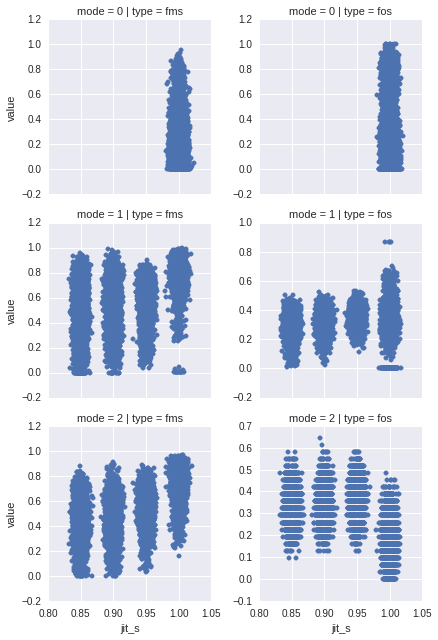

In [14]:
simDF['theta'] = simDF['theta'].astype('category')
simDF['jit_s'] = rand_jitter(simDF['sparsity'], 0.005)
g = sns.FacetGrid(simDF, col="type", row="mode", sharey=False)
g = (g.map(plt.scatter, "jit_s", "value")
     .add_legend())

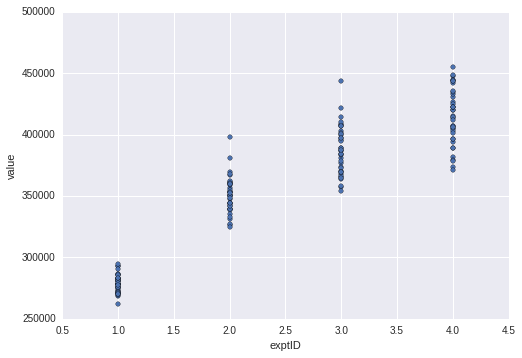

In [10]:
g2 = llDF.plot(kind="scatter", x="exptID", y="value")

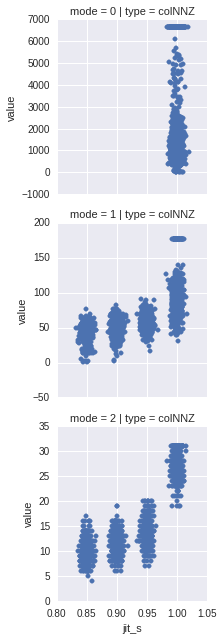

In [13]:
sparseDF['jit_s'] = rand_jitter(sparseDF['sparsity'], 0.005)
g = sns.FacetGrid(sparseDF, col="type", row="mode", sharey=False)
g = (g.map(plt.scatter, "jit_s", "value")
     .add_legend())

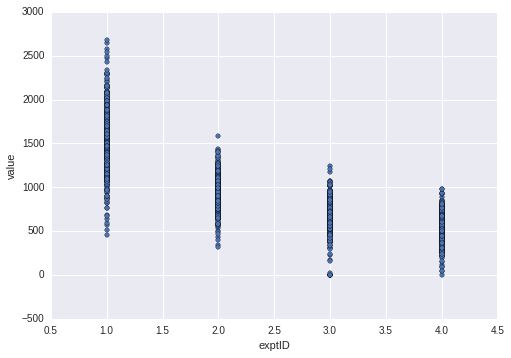

In [15]:
g2 = weightDF.plot(kind="scatter", x="exptID", y="value")